In [ ]:
import multiprocessing
import os
import time
import numpy as np
from scipy.spatial import cKDTree
import open3d as o3d
import util
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
import random
from BendLength import BendLengthCalculator

In [ ]:
point_cloud_location = "/home/chris/Code/PointClouds/data/ply/CircularVentilationGrateExtraCleanedFull.ply"
pcd = o3d.io.read_point_cloud(point_cloud_location)

In [ ]:
# Preprocess the point cloud
pcd = util.preProcessCloud(pcd)
pcd_points = np.asarray(pcd.points)

# Detect planes, intersections, and anchor points
segment_models, segments, main_surface_idx = util.multiOrderRansac(pcd, pt_to_plane_dist=0.4)
angles_rad = util.findAnglesBetweenPlanes(segment_models, main_surface_idx)
intersection_lines = util.findIntersectionLines(segment_models, main_surface_idx)
anchor_points = util.findAnchorPoints(segment_models, segments, intersection_lines, main_surface_idx)

sample_dist = 0.3
aggregation_range = 15
eigen_threshold = 0.05
angle_threshold = 0.12
radius = 1.5
bend_length_calculator = BendLengthCalculator(pcd, anchor_points, intersection_lines, eigen_threshold, angle_threshold, aggregation_range, sample_dist, radius)
bend_edges = bend_length_calculator.compute_bend_lengths()

In [ ]:
# Calculate per point normal variance and 'core' points
all_normals, pointwise_variance = util.calculatePointwiseNormalVariance(pcd, radius=2)
core_indices = util.getCorePoints(pointwise_variance)

In [ ]:
clusters = util.growRegionsAroundIntersections(anchor_points, core_indices, pointwise_variance, pcd_points, bend_edges, variance_percentile=95)

# def visualize_clusters(points, clusters):
#     """
#     Visualizes clusters in a point cloud with each cluster having a unique color.

#     Args:
#         points (np.ndarray): The full point cloud (Nx3).
#         clusters (list of sets): A list where each set contains indices of points in a cluster.
#     """
#     num_points = len(points)
#     colors = np.full((num_points, 3), fill_value=0.5)  # Default gray color for unclustered points
    
#     # Generate unique colors for each cluster
#     cmap = plt.get_cmap("tab20")  # Use tab20 colormap for distinct colors
#     cluster_colors = [cmap(i % 20)[:3] for i in range(len(clusters))]  # RGB values from colormap
    
#     # Assign colors to clustered points
#     for cluster_idx, cluster in enumerate(clusters):
#         cluster_color = cluster_colors[cluster_idx]
#         for idx in cluster:
#             colors[idx] = cluster_color  # Color each point in the cluster
    
#     # Create an Open3D point cloud object
#     pcd = o3d.geometry.PointCloud()
#     pcd.points = o3d.utility.Vector3dVector(points)
#     pcd.colors = o3d.utility.Vector3dVector(colors)

#     # Visualize
#     o3d.visualization.draw_geometries([pcd])

# # Call visualization function
# visualize_clusters(pcd_points, clusters)

In [ ]:
class GaussMapVisualizer:
    def __init__(self, pcd, all_normals, standard_deviations, clusters, radius):
        self.pcd = pcd
        self.points = np.asarray(pcd.points)
        self.pcd.paint_uniform_color([0.6, 0.6, 0.6])
        self.kdtree = cKDTree(self.points)
        self.plane_directions = all_normals
        self.clusters = clusters
        self.radius = radius
        self.standard_deviations = standard_deviations
        low, high = np.percentile(self.standard_deviations, [95, 100])
        self.core_indices = np.where((self.standard_deviations > low) & (self.standard_deviations <= high))[0]
        #print(f"Found {len(self.core_indices)} core points out of {len(self.pcd.points)} total points.")
        self.reference_normal = None
        self.heatmap_mode = False  # Default mode: Bend visualization
        self.use_global_percentile = False
        self.current_index = 0
        self.vis = o3d.visualization.VisualizerWithKeyCallback()
        self.vis.create_window("GaussMapVisualizer")

        # **Register callback to toggle heatmap mode**
        self.vis.register_key_callback(263, self.toggle_heatmap)
        self.vis.register_key_callback(262, self.next_neighborhood)
        self.vis.register_key_callback(264, self.show_random_core_point)
        self.vis.add_geometry(self.pcd)
        self.apply_variation_heatmap(self.clusters)
        self._update_neighborhood()

    def toggle_heatmap(self, vis):
        self.heatmap_mode = not self.heatmap_mode  # Flip mode
        print(f'self.heatmap_mode: {self.heatmap_mode}')

        if self.heatmap_mode:
            self.apply_full_heatmap()
            print("Switched to Full Point Cloud Heatmap Mode.")
        else:
            self.apply_variation_heatmap(self.clusters)
            print("Switched to Bends-Only Mode.")

        vis.update_geometry(self.pcd)
        # vis.poll_events()
        # vis.update_renderer()

    def apply_full_heatmap(self):
        """ Apply full heatmap coloring based on normal variance. """
        colors = self.normalize_variation_colors(self.standard_deviations)
        self.pcd.colors = o3d.utility.Vector3dVector(colors)

    def get_nearest_neighbor_directions(self, point, kdtree, pcd, plane_directions, radius=2):
        """ Get the directions of the k nearest neighbors to a given point. """
        idx = kdtree.query_ball_point(point, radius)
        nearest_points = np.asarray(pcd.points)[idx]
        nearest_directions = np.asarray(plane_directions)[idx]
        return idx, nearest_points, nearest_directions
    
    def create_normal_lines(self, neighbor_points, neighbor_directions, scale=0.2):
        """ Create line segments for the normal directions at each point. """
        line_set = o3d.geometry.LineSet()

        start_points = np.array(neighbor_points)
        end_points = start_points + scale * np.array(neighbor_directions)
        lines = [[start_points[i], end_points[i]] for i in range(len(neighbor_points))]
        line_set.points = o3d.utility.Vector3dVector(np.concatenate(lines, axis=0))
        line_indices = [[i, i + 1] for i in range(0, len(lines) * 2, 2)]
        line_set.lines = o3d.utility.Vector2iVector(line_indices)
        line_set.colors = o3d.utility.Vector3dVector(np.tile((0, 0, 1), (len(lines), 1)))
        return line_set
    
    def align_normals(self, reference_normal, neighbor_directions):
        aligned_normals = np.array(neighbor_directions)
        
        # Check dot product: If negative, flip the normal
        for i in range(len(aligned_normals)):
            if np.dot(reference_normal, aligned_normals[i]) < 0:
                aligned_normals[i] = -aligned_normals[i]

        return aligned_normals
    
    def calculate_normal_variation(self, normals):
        mu = np.mean(normals, axis=0)
        norm = normals - mu
        cov = np.cov(norm.T)
        eig_val, _ = np.linalg.eig(cov)
        sorted_idx = np.argsort(eig_val)[::-1]
        eig_val = eig_val[sorted_idx]
        eig_val_norm = eig_val / np.sum(eig_val)
        
        return mu, eig_val_norm, cov
    
    def update_gauss_map(self, normals):
        """ Update the Gauss Map visualization with the current neighborhood's normals. """
        normals = np.array(normals)
        normals /= np.linalg.norm(normals, axis=1, keepdims=True)  # Normalize to unit sphere

        # Create figure
        plt.figure("Gauss Map", figsize=(6, 6))
        plt.clf()  # Clear previous plot
        ax = plt.subplot(111, projection="3d")

        # Plot unit sphere
        u = np.linspace(0, 2 * np.pi, 30)
        v = np.linspace(0, np.pi, 20)
        x = np.outer(np.cos(u), np.sin(v))
        y = np.outer(np.sin(u), np.sin(v))
        z = np.outer(np.ones(np.size(u)), np.cos(v))
        ax.plot_surface(x, y, z, color="gray", alpha=0.3, edgecolor="none")  # Transparent sphere

        # Plot normal vectors
        for normal in normals:
            ax.quiver(0, 0, 0, normal[0], normal[1], normal[2], color="b", linewidth=1, arrow_length_ratio=0.1)

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
        ax.set_title(f"Gauss Map - Neighborhood {self.current_index}")

        plt.pause(0.1)  # Allow Matplotlib to update

    def show_random_core_point(self, vis):
        if len(self.core_indices) == 0:
            print("No core points found.")
            return

        # Pick a random core point
        self.current_index = random.choice(self.core_indices)

        # Visualize its neighborhood
        self._update_neighborhood()

        print(f"Showing core point {self.current_index}.")

    def _update_neighborhood(self):
        """ Update visualization for the current neighborhood. """
        # Get the currently selected point
        query_point = np.asarray(self.pcd.points)[self.current_index]

        # Get nearest neighbors
        idx, neighbor_points, neighbor_directions = self.get_nearest_neighbor_directions(query_point, self.kdtree, self.pcd, self.plane_directions, radius=self.radius)
        if self.current_index==0:
            self.reference_normal = neighbor_directions[0]

        aligned_directions = self.align_normals(self.reference_normal, neighbor_directions)
        normal_mean, normal_variation, cov_after = self.calculate_normal_variation(aligned_directions)

        if hasattr(self, "normal_lines"):
            self.vis.remove_geometry(self.normal_lines)
        self.normal_lines = self.create_normal_lines(neighbor_points, aligned_directions, scale=2)
        self.vis.add_geometry(self.normal_lines)
        view_ctl = self.vis.get_view_control()
        lookat = query_point
        zoom = 0.080000000000000002
        front = [-0.024106890455448116,-0.57254772319971181,0.81951690799604338]
        up =  [0.014828165865396817,0.81946017828866602,0.57294427451208185]
        view_ctl.set_lookat(lookat)  # Set the point the camera is looking at
        view_ctl.set_up(up)      # Set the up direction of the camera
        view_ctl.set_front(front)  # Set the front direction of the camera
        view_ctl.set_zoom(zoom)          # Set the zoom factor of the camera

        self.update_gauss_map(aligned_directions)

        self.vis.update_geometry(self.pcd)
        print(f"Neighborhood {self.current_index}/{len(self.pcd.points)} updated", flush=True)
        #print(f'Aligned normals: {neighbor_directions}', flush=True)
        #print(f"Normal mean: {normal_mean}, Normal variation: {normal_variation}", flush=True)
        #print(f"Std Dev of Normals: {np.std(neighbor_directions, axis=0)}")
        #print(f"Condition Number of Covariance: {np.linalg.cond(cov_after)}")
        print(15*"-", flush=True)

    def next_neighborhood(self, vis):
        """ Move to the next neighborhood when right arrow key is pressed. """
        self.current_index = (self.current_index + 500) % len(self.pcd.points)
        self._update_neighborhood()
    
    def normalize_variation_colors(self, variation_values, use_global=False):
        """ 
        Normalize variation values to a colormap range.
        
        Args:
            variation_values (np.ndarray): The normal variance values.
            use_global (bool): Whether to use global percentile normalization.
        
        Returns:
            np.ndarray: RGB colors mapped from a colormap.
        """
        if use_global:
            min_val, max_val = np.percentile(self.standard_deviations, [2, 98])  # Use all points
        else:
            min_val, max_val = np.percentile(variation_values, [2, 98])  # Use local cluster

        norm_variation = (variation_values - min_val) / (max_val - min_val + 1e-6)  # Normalize to [0,1]
        colors = cm.viridis(np.clip(norm_variation, 0, 1))[:, :3]  # Extract RGB colors

        return colors
    
    def toggle_global_percentile(self, vis):
        """ Toggle between local and global percentile normalization. """
        self.use_global_percentile = not self.use_global_percentile  # Flip mode
        self.apply_variation_heatmap(self.clusters)  # Reapply colors

        mode = "Global" if self.use_global_percentile else "Local"
        print(f"Switched to {mode} Percentile Normalization.")

        vis.update_geometry(self.pcd)

    def apply_variation_heatmap(self, clusters, unclustered_color=(0.7, 0.7, 0.7)):
        """
        Colors clustered points using the heatmap and assigns a uniform color to unclustered points.

        Args:
            clusters (list of sets): List of clusters, where each set contains indices of points in a cluster.
            unclustered_color (tuple): RGB color for unclustered points (default: light gray).
        """
        num_points = len(self.points)
        colors = np.full((num_points, 3), fill_value=unclustered_color)  # Default: all points = light gray

        clustered_indices = np.array([idx for cluster in clusters for idx in cluster])

        if clustered_indices.size > 0:
            clustered_variance = self.standard_deviations[clustered_indices]

            # **Use global or local percentile normalization**
            clustered_colors = self.normalize_variation_colors(clustered_variance, use_global=self.use_global_percentile)

            # **Apply heatmap colors to clustered points**
            colors[clustered_indices] = clustered_colors  

        self.pcd.colors = o3d.utility.Vector3dVector(colors)

        mode = "Global" if self.use_global_percentile else "Local"
        print(f"Applied {mode} Percentile Heatmap to Clusters.")


    def run(self):
        self.vis.run()  # Start the visualization loop (blocks until closed)
        self.vis.destroy_window()

Found 105714 core points out of 2114266 total points.
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).


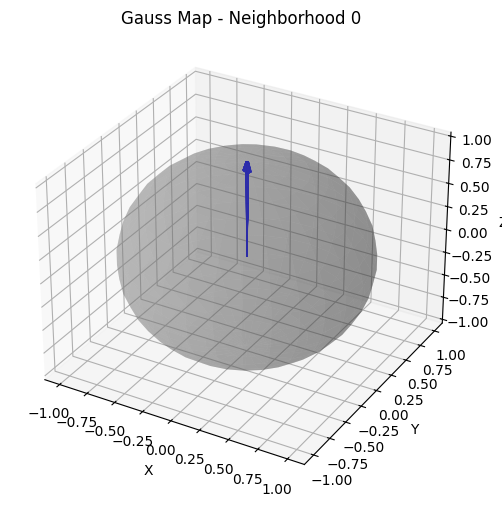

Neighborhood 0/2114266 updated
---------------
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).
self.heatmap_mode: True
Switched to Full Point Cloud Heatmap Mode.
self.heatmap_mode: False
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).
Switched to Bends-Only Mode.
self.heatmap_mode: True
Switched to Full Point Cloud Heatmap Mode.
self.heatmap_mode: False
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).
Switched to Bends-Only Mode.
self.heatmap_mode: True
Switched to Full Point Cloud Heatmap Mode.
self.heatmap_mode: False
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).
Switched to Bends-Only Mode.
self.heatmap_mode: True
Switched to Full Point Cloud Heatmap Mode.
self.heatmap_mode: False
Clustered points are colored using the heatmap, unclustered points are (0.7, 0.7, 0.7).
Switched to Bends-Only Mode.
self.heatmap_mode: True


In [ ]:
visualizer = GaussMapVisualizer(pcd, all_normals, pointwise_variance, clusters, radius=2)
visualizer.apply_variation_heatmap(clusters)  # Apply cluster + heatmap visualization
visualizer.run()